## Importing the relevant packages and downloading the pre trained Vgg16 model from keras

In [1]:
import os, sys
import glob
import shutil
import zipfile
import numpy as np
from numpy.random import random, permutation
from keras import applications
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib import pyplot as plt
import time

Using TensorFlow backend.


In [2]:
vgg_model = applications.VGG16(weights='imagenet', include_top=True)

In [3]:
!sudo find / -iname 'vgg16_weights_tf_dim_ordering_tf_kernels.h5' -print

/home/ubuntu/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5


## Data management
1. Making the following directories a. train b. valid c. test
2. Move 20% of train data into valid


In [4]:
%matplotlib inline

In [5]:
os.getcwd()

'/home/ubuntu'

In [6]:
data_path = "/home/ubuntu/Data/"
os.chdir(data_path)
print(os.getcwd())
print(os.stat(data_path).st_size)
for file in os.scandir(data_path):
    print(file.name)
os.chdir(data_path + 'Train/Malignant')
print('Malignant sample')
!ls | head -n 5
!ls | tail -n 5
os.chdir(data_path + 'Train/Non-Malignant')
print('Non-Malignant sample')
!ls | head -n 5
!ls | tail -n 5



/home/ubuntu/Data
4096
Test
Train
Malignant sample
ISIC_0000002.jpg
ISIC_0000004.jpg
ISIC_0000013.jpg
ISIC_0000022.jpg
ISIC_0000026.jpg
ls: write error: Broken pipe
ISIC_0010767.jpg
ISIC_0010770.jpg
ISIC_0010772.jpg
ISIC_0010777.jpg
ISIC_0010778.jpg
Non-Malignant sample
ISIC_0000000.jpg
ISIC_0000001.jpg
ISIC_0000003.jpg
ISIC_0000005.jpg
ISIC_0000006.jpg
ISIC_0000545.jpg
ISIC_0000546.jpg
ISIC_0000556.jpg
ISIC_0000557.jpg
ISIC_0000558.jpg


In [7]:
os.chdir(data_path)

## Creating validation dataset from the data

In [8]:
def create_validation_data(in_dir, out_dir, valid_percent):

    valid_size = int(len([name for name in os.listdir(in_dir)]) * valid_percent)
    os.chdir(in_dir)
    g = glob.glob('*.jpg')
    shuffled = np.random.permutation(g)
    if not int(len([name for name in os.listdir(out_dir)])):
        for i in range(valid_size): 
            shutil.move(shuffled[i], out_dir + shuffled[i])
    valid_data_size = len([name for name in os.listdir(out_dir)])
    print(valid_data_size, out_dir)

In [9]:
if not os.path.exists(data_path + 'valid'):
    os.makedirs('valid/Malignant')
    os.makedirs('valid/Non-Malignant')
    create_validation_data((data_path + 'Train/Malignant'), (data_path + 'valid' + '/Malignant/'), 0.2)
    create_validation_data((data_path + 'Train/Non-Malignant'), (data_path + 'valid' + '/Non-Malignant/'), 0.2)

80 /home/ubuntu/Data/valid/Malignant/
80 /home/ubuntu/Data/valid/Non-Malignant/


In [10]:
path = data_path 
model_path = path + 'models/'
if not os.path.exists(model_path): 
    os.mkdir(model_path)

## Model workflow
1. Create a process for batch generation from training and validation data
2. Check the data shape of inputs and labels and make changes, if necessary

In [11]:
batch_size=20

## Some useful keras tools
Keras provides some useful image pre processing tools
1. ImageDataGenerator() - does real time augmentation of the image and produces an image of a target size. This is necessary when the input images may not be of same size
2. flow_from_directory method in ImageDataGenerator() creates batches (default batch_size=32) of data provided the data is stored in sub directories which will be presumed to be each of a class.

## Data preprocessing
1. Image augmentation (all images need to be of the same size)
2. Creating bacthes of data

In [12]:
#we are using the default values of ImageDataGenerator. If the number of images are few, then additional images can be
#created in the folders using data augmentation as illustrated in the following cells

def classes_from_dir(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=batch_size, class_mode='binary',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [13]:
val_batch_class = classes_from_dir(path+'valid', shuffle=False, batch_size=batch_size)
trn_batch_class = classes_from_dir(path+'Train', shuffle=False, batch_size=batch_size)

Found 160 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


In [14]:
def get_data(path, batch_size, target_size=(224,224)):
    batch_class = classes_from_dir(path, shuffle=False, batch_size=batch_size, class_mode=None, target_size=target_size)
    return np.concatenate([batch_class.next() for i in range(int(batch_class.samples/batch_size))])

In [15]:
val_data = get_data(path+'valid',batch_size)
trn_data = get_data(path+'Train',batch_size)

Found 160 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


In [16]:
trn_data.shape

(640, 224, 224, 3)

In [17]:
val_data.shape

(160, 224, 224, 3)

In [18]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [19]:
val_classes = val_batch_class.classes
trn_classes = trn_batch_class.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [20]:
trn_labels.shape

(640, 2)

In [21]:
trn_classes[:2]

array([0, 0], dtype=int32)

In [22]:
trn_labels[:5]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [23]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
vgg_model.layers.pop()
for layer in vgg_model.layers: layer.trainable=False
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [25]:
from keras.models import Model
new_layer = Dense(2, activation='softmax', name='predictions')
inp = vgg_model.input
out = new_layer(vgg_model.layers[-1].output)
model2 = Model(inp, out)

In [26]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Batches and model without using Image Augmentation


In [27]:
batches = image.ImageDataGenerator().flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = image.ImageDataGenerator().flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

In [28]:
def fit_model(model, batches, val_batches, batch_size, nb_epoch=1):
    model.fit_generator(batches, steps_per_epoch=batches.n/batch_size, epochs=nb_epoch, 
                        validation_data=val_batches, validation_steps=val_batches.n/batch_size)

In [29]:
print(batches.n)

640


In [30]:
model2.save_weights(model_path+'run_test4-bat100-epoch-'+'init'+'-'+'vgg16.h5')
opt = Adam(lr=0.001, decay=1e-06)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### Saving the model weights periodically will let you revert easily to a better model if overfitting occurs

In [31]:
num_of_epochs = 5
for i in range(num_of_epochs):
    start = time.time()
    fit_model(model2, batches, val_batches, batch_size, nb_epoch=1)
    model2.save_weights(model_path+'run_test4-bat100-epoch-'+str(i+1)+'-'+'vgg16.h5')
    end = time.time()
    print(end - start)

Epoch 1/1
32/32 [==============================] - 21s - loss: 0.7232 - acc: 0.6875 - val_loss: 0.6395 - val_acc: 0.7188
21.733748197555542
Epoch 1/1
32/32 [==============================] - 17s - loss: 0.4177 - acc: 0.7875 - val_loss: 0.8030 - val_acc: 0.7125
18.218661069869995
Epoch 1/1
32/32 [==============================] - 17s - loss: 0.4683 - acc: 0.7828 - val_loss: 0.8046 - val_acc: 0.6500
18.22871685028076
Epoch 1/1
32/32 [==============================] - 17s - loss: 0.3989 - acc: 0.8188 - val_loss: 0.8501 - val_acc: 0.7125
18.28011703491211
Epoch 1/1
32/32 [==============================] - 17s - loss: 0.3010 - acc: 0.8719 - val_loss: 0.6831 - val_acc: 0.7125
18.31449246406555


## Loading weights from last saved weights

In [32]:

model2.load_weights(model_path+'run_test4-bat100-epoch-'+str(1)+'-'+'vgg16.h5')
opt = Adam(lr=0.001, decay=1e-06)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
num_of_epochs = 5
for i in range(num_of_epochs):
    start = time.time()
    fit_model(model2, batches, val_batches, batch_size, nb_epoch=1)
    model2.save_weights(model_path+'run_test4-bat100-epoch-'+str(i+2)+'-'+'vgg16.h5')
    end = time.time()
    print(end - start)

Epoch 1/1
32/32 [==============================] - 17s - loss: 0.5630 - acc: 0.7422 - val_loss: 0.6944 - val_acc: 0.7000
23.30616593360901
Epoch 1/1
32/32 [==============================] - 17s - loss: 0.4488 - acc: 0.7859 - val_loss: 0.8226 - val_acc: 0.7188
23.03525471687317
Epoch 1/1
32/32 [==============================] - 17s - loss: 0.3560 - acc: 0.8281 - val_loss: 0.7240 - val_acc: 0.7250
23.07470393180847
Epoch 1/1
32/32 [==============================] - 17s - loss: 0.2643 - acc: 0.8937 - val_loss: 0.7287 - val_acc: 0.7000
23.05155062675476
Epoch 1/1
32/32 [==============================] - 17s - loss: 0.2564 - acc: 0.8969 - val_loss: 0.7066 - val_acc: 0.7063
18.286210536956787


## Inspecting the results on validation data

In [34]:

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


In [35]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

In [36]:
# We want both the classes...
probs = model2.predict(val_data, batch_size=batch_size)
probs = np.round(probs, 2)
probs[:, 0]
preds = probs.argmax(axis=-1)
preds[:4]

array([0, 0, 0, 1])

In [37]:
filenames = val_batch_class.filenames

In [38]:
# Number of images to view for each visualization task
n_view = 4

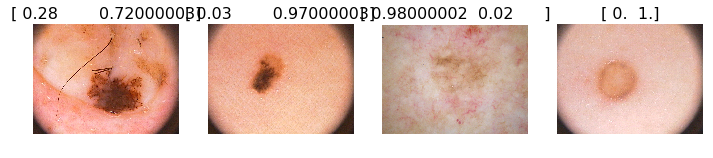

In [39]:
#1. A few correct labels at random [malignant(event) non-malignant(non-event)] 

correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

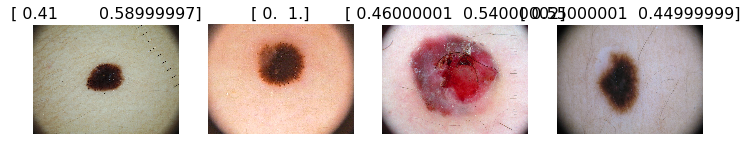

In [40]:
#2. A few incorrect labels at random[malignant(event) non-malignant(non-event)] 

incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

## Confusion matrix is a good way to visualize the quality of classification 

In [41]:
cm = confusion_matrix(val_classes, preds)

In [42]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


[[57 23]
 [24 56]]


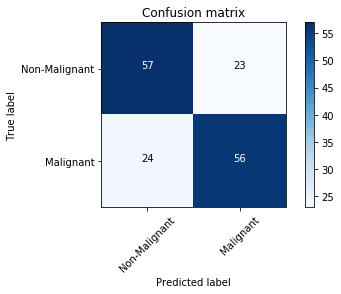

In [43]:
plot_confusion_matrix(cm, val_batch_class.class_indices)

# Batches  using Image Augmentation

In [44]:

batches = image.ImageDataGenerator(rotation_range=10.0, width_shift_range=0.1, height_shift_range=0.1, 
                             shear_range=0.15, zoom_range=0.1, channel_shift_range=10.0, 
                             fill_mode='nearest', cval=0.0, horizontal_flip=True, vertical_flip=False).flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = image.ImageDataGenerator(rotation_range=10.0, width_shift_range=0.1, height_shift_range=0.1, 
                             shear_range=0.15, zoom_range=0.1, channel_shift_range=10.0, 
                             fill_mode='nearest', cval=0.0, horizontal_flip=True, vertical_flip=False).flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

## Model using Image Augmented Data

In [45]:
def fit_model(model, batches, val_batches, batch_size, nb_epoch=1):
    model.fit_generator(batches, steps_per_epoch=batches.n/batch_size, epochs=nb_epoch, 
                        validation_data=val_batches, validation_steps=val_batches.n/batch_size)

In [46]:
print(batches.n)

640


In [47]:
#opt = RMSprop(lr=0.1)
model2.save_weights(model_path+'run_test4-bat100-epoch-'+'init'+'-'+'vgg16.h5')
opt = Adam(lr=0.001, decay=1e-06)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
num_of_epochs = 5
for i in range(num_of_epochs):
    start = time.time()
    fit_model(model2, batches, val_batches, batch_size, nb_epoch=1)
    model2.save_weights(model_path+'run_test4-bat100-epoch-'+str(i+1)+'-'+'vgg16.h5')
    end = time.time()
    print(end - start)

Epoch 1/1
32/32 [==============================] - 18s - loss: 0.5273 - acc: 0.7703 - val_loss: 0.6284 - val_acc: 0.7375
23.509202480316162
Epoch 1/1
32/32 [==============================] - 18s - loss: 0.6495 - acc: 0.7281 - val_loss: 0.7084 - val_acc: 0.7125
23.440444946289062
Epoch 1/1
32/32 [==============================] - 18s - loss: 0.5166 - acc: 0.7641 - val_loss: 0.7296 - val_acc: 0.7250
23.328081369400024
Epoch 1/1
32/32 [==============================] - 18s - loss: 0.4745 - acc: 0.7797 - val_loss: 0.6197 - val_acc: 0.7125
23.37873888015747
Epoch 1/1
32/32 [==============================] - 18s - loss: 0.3973 - acc: 0.8281 - val_loss: 0.7118 - val_acc: 0.7000
23.31689167022705


## Load weights from last saved weights

In [49]:

model2.load_weights(model_path+'run_test4-bat100-epoch-'+str(1)+'-'+'vgg16.h5')
opt = Adam(lr=0.001, decay=1e-06)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
num_of_epochs = 5
for i in range(num_of_epochs):
    start = time.time()
    fit_model(model2, batches, val_batches, batch_size, nb_epoch=1)
    model2.save_weights(model_path+'run_test4-bat100-epoch-'+str(i+2)+'-'+'vgg16.h5')
    end = time.time()
    print(end - start)

Epoch 1/1
32/32 [==============================] - 18s - loss: 0.5324 - acc: 0.7500 - val_loss: 0.6547 - val_acc: 0.7250
23.55630326271057
Epoch 1/1
32/32 [==============================] - 18s - loss: 0.4458 - acc: 0.8047 - val_loss: 0.7790 - val_acc: 0.7188
23.34219527244568
Epoch 1/1
32/32 [==============================] - 18s - loss: 0.4487 - acc: 0.7938 - val_loss: 0.7588 - val_acc: 0.6812
23.390441179275513
Epoch 1/1
32/32 [==============================] - 18s - loss: 0.4693 - acc: 0.7859 - val_loss: 0.7118 - val_acc: 0.7125
23.349031448364258
Epoch 1/1
32/32 [==============================] - 18s - loss: 0.4478 - acc: 0.7969 - val_loss: 0.7176 - val_acc: 0.6875
23.374258518218994


## Inspecting results on validation data

In [51]:

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


In [52]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

In [53]:
# We want both the classes...
probs = model2.predict(val_data, batch_size=batch_size)
probs = np.round(probs, 5)
probs[:, 0]
preds = probs.argmax(axis=-1)
preds[:4]

array([1, 0, 0, 1])

In [54]:
filenames = val_batch_class.filenames

In [55]:
# Number of images to view for each visualization task
n_view = 4

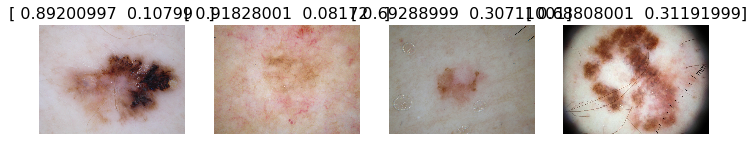

In [56]:
#1. A few correct labels at random[malignant(event) non-malignant(non-event)] 

correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

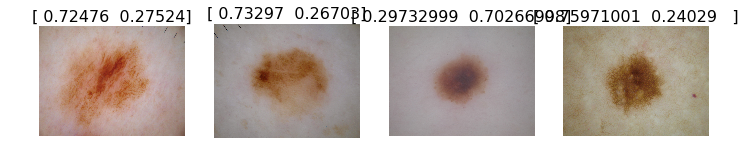

In [57]:
#2. A few incorrect labels at random[malignant(event) non-malignant(non-event)] 

incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

## Confusion matrix is a good way to visualize the quality of classification 

In [58]:
cm = confusion_matrix(val_classes, preds)

In [59]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


[[55 25]
 [19 61]]


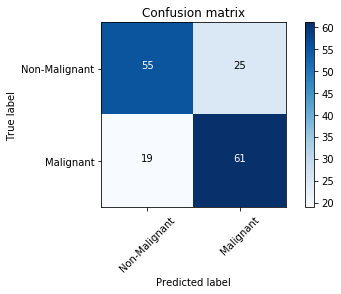

In [60]:
plot_confusion_matrix(cm, val_batch_class.class_indices)

### From the confusion matrix we see, that false negative for augmented model is 23.75% and the non-augmented model is 30%.
### Also the accuracy of augmented model from confusion matrix is 78.85% which is 70.625% for non-augmented model. 
### Hence we choose the model with augmentation for scoring the test data.

### For testing, the malignant images have to be put into a sub directory 

In [61]:

test_path = data_path+'Test/Malignant/'
print(test_path)
if not os.path.exists(test_path):
    os.mkdir(test_path)

/home/ubuntu/Data/Test/Malignant/


In [62]:
#need to have folder for the test data for the classes in this case unknown because we are using flow_from_directory
#in our function classes_from_dir which we use later for test images

if not os.path.exists(test_path+'unknown/'):
    os.mkdir(test_path+'unknown/')  
    in_dir = os.listdir(test_path)
    os.chdir(data_path+'Test/Malignant')
    g = glob.glob('*.jpg')
    shuffle = np.random.permutation(g)
    for file in in_dir:

        shutil.move(file, test_path+'unknown/')
path, dirs, files = os.walk(test_path+'unknown/').__next__()
print(len(files))

80


In [63]:
os.getcwd()

'/home/ubuntu/Data/Test/Malignant'

## Some inspection on the predictions of malignant test images

In [64]:
test_image_path = test_path
def test_plots_idx(idx, path, titles=None):
    plots([image.load_img(path + test_batches.filenames[i]) for i in idx], titles=titles)

In [65]:
def test_gen(path, batch_size):
    test_batches = classes_from_dir(path, shuffle=False, batch_size=batch_size, class_mode='binary')
    return test_batches, model2.predict_generator(test_batches, test_batches.n/batch_size)

In [66]:
test_batch_size = 20
test_batches, preds = test_gen(test_path, test_batch_size)

Found 80 images belonging to 1 classes.


In [67]:
print(len(np.rint(preds[:,1])))

80


In [68]:
test_batches.filenames[:5]

['unknown/ISIC_0026586.jpg',
 'unknown/ISIC_0027076.jpg',
 'unknown/ISIC_0027149.jpg',
 'unknown/ISIC_0026738.jpg',
 'unknown/ISIC_0027033.jpg']

In [69]:
is_malign = np.where(np.rint(preds[:,0])==1)
idx = np.squeeze(is_malign)
print(len(idx))
idx = idx[1:5]
print(idx)

55
[2 3 4 5]


In [70]:
print(preds[:,0])

[  9.84923482e-01   4.50312234e-02   8.70691478e-01   9.02385414e-01
   8.17963600e-01   9.32376504e-01   8.04143846e-01   8.35938513e-01
   8.53823781e-01   6.40051007e-01   7.20595002e-01   6.69416487e-01
   7.39749908e-01   7.47298360e-01   2.27710739e-01   1.35294601e-01
   8.70843947e-01   6.84975028e-01   3.50413173e-02   6.91638589e-01
   8.71725380e-01   9.86756563e-01   3.55528206e-01   5.98421693e-01
   7.29334116e-01   5.81610978e-01   9.90580022e-01   3.72914732e-01
   7.26605117e-01   9.73944902e-01   9.53172266e-01   8.94130290e-01
   7.46306658e-01   5.71627855e-01   4.40137684e-01   6.41128838e-01
   7.50698328e-01   5.48773229e-01   8.23370576e-01   7.58841097e-01
   9.92058337e-01   9.81760561e-01   8.92469168e-01   3.45522255e-01
   6.34273589e-01   1.65948853e-01   9.99367774e-01   8.63646150e-01
   3.90044928e-01   9.91269350e-01   7.95704961e-01   6.93304539e-01
   2.54112571e-01   2.94828322e-04   7.92570651e-01   2.08234861e-02
   3.21770161e-01   9.87441659e-01

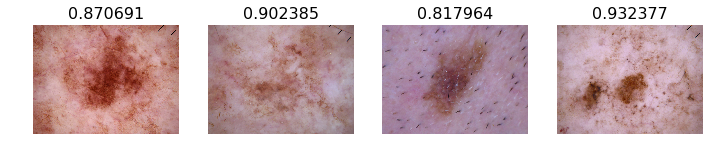

In [72]:
test_plots_idx(idx, test_image_path, preds[:,0][idx])

In [73]:
ids = [int(f[13:f.find('.')]) for f in test_batches.filenames]
print(len(ids))

80


In [74]:
is_malign = preds[:,1]
# an useful trick, if the eval criteria is log-loss, because 0 or 1 predictions, 
#or over confident predictions are penalized
# if accuracy was the eval criteria, then 1 and 0's are expected and the predictions should be accordingly converted
is_malign = np.squeeze(is_malign)
is_malign = np.clip(is_malign, 0.03, 0.97) 
print(len(is_malign))
print(is_malign[:5])

80
[ 0.03        0.95496875  0.1293086   0.09761462  0.18203636]


### For testing, the non-malignant images have to be put into a sub directory 

In [75]:

test_path = data_path+'Test/Non-Malignant/'
print(test_path)
if not os.path.exists(test_path):
    os.mkdir(test_path)

/home/ubuntu/Data/Test/Non-Malignant/


In [76]:
#need to have folder for the test data for the classes in this case unknown because we are using flow_from_directory
#in our function classes_from_dir which we use later for test images

if not os.path.exists(test_path+'unknown/'):
    os.mkdir(test_path+'unknown/')  
    in_dir = os.listdir(test_path)
    os.chdir(data_path+'Test/Non-Malignant')
    g = glob.glob('*.jpg')
    shuffle = np.random.permutation(g)
    for file in in_dir:

        shutil.move(file, test_path+'unknown/')
path, dirs, files = os.walk(test_path+'unknown/').__next__()
print(len(files))

80


In [77]:
os.getcwd()

'/home/ubuntu/Data/Test/Non-Malignant'

## Some inspection on the predictions of non-malignant test data

In [78]:
test_image_path = test_path
def test_plots_idx(idx, path, titles=None):
    plots([image.load_img(path + test_batches.filenames[i]) for i in idx], titles=titles)

In [79]:
def test_gen(path, batch_size):
    test_batches = classes_from_dir(path, shuffle=False, batch_size=batch_size, class_mode='binary')
    return test_batches, model2.predict_generator(test_batches, test_batches.n/batch_size)

In [80]:
test_batch_size = 20
test_batches, preds = test_gen(test_path, test_batch_size)

Found 80 images belonging to 1 classes.


In [81]:
print(len(np.rint(preds[:,1])))

80


In [82]:
test_batches.filenames[:5]

['unknown/nm (49).jpg',
 'unknown/nm (16).jpg',
 'unknown/nm (4).jpg',
 'unknown/nm (56).jpg',
 'unknown/nm (13).jpg']

In [93]:
is_nonmalign = np.where(np.rint(preds[:,1])==1)
idx = np.squeeze(is_nonmalign)
print(len(idx))
idx = idx[1:5]
print(idx)

44
[1 2 3 4]


In [94]:
print(preds[:,1])

[  9.40655768e-01   8.23147714e-01   6.65140271e-01   6.69607580e-01
   9.85902548e-01   5.10482013e-01   9.93637562e-01   6.15710378e-01
   9.88320887e-01   6.70080423e-01   9.99747813e-01   4.61557209e-01
   8.76378357e-01   2.44797513e-01   5.81635416e-01   1.54558450e-01
   3.84789556e-01   7.46567667e-01   5.07758975e-01   2.42618009e-01
   3.45737517e-01   8.84051842e-04   5.13606787e-01   1.39580563e-01
   9.93377984e-01   4.22561377e-01   9.91505802e-01   2.60529488e-01
   1.88390031e-01   1.08846463e-01   1.46398902e-01   6.21497691e-01
   2.44797513e-01   9.99936223e-01   9.90793884e-01   7.48116910e-01
   7.73978382e-02   1.46721527e-01   8.10796559e-01   7.23482490e-01
   9.88440752e-01   5.52457094e-01   1.28390014e-01   8.55539262e-01
   3.45689505e-01   2.37249613e-01   1.09862044e-01   4.02664989e-01
   8.25072110e-01   9.99614954e-01   9.70934033e-01   9.92813408e-01
   9.95972574e-01   9.34961081e-01   4.70433295e-01   6.89313889e-01
   8.33771899e-02   7.33950317e-01

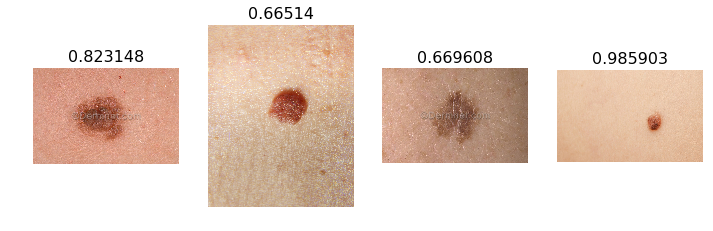

In [95]:
test_plots_idx(idx, test_image_path, preds[:,1][idx])

In [97]:
ids = [int(f[12:f.find(')')]) for f in test_batches.filenames]
print(len(ids))

80


In [98]:
is_malign = preds[:,1]
# an useful trick, if the eval criteria is log-loss, because 0 or 1 predictions, 
#or over confident predictions are penalized
# if accuracy was the eval criteria, then 1 and 0's are expected and the predictions should be accordingly converted
is_malign = np.squeeze(is_malign)
is_malign = np.clip(is_malign, 0.03, 0.97) 
print(len(is_malign))
print(is_malign[:5])

80
[ 0.94065577  0.82314771  0.66514027  0.66960758  0.97000003]
